# VAEでクラス識別ができないか検討してみる
- 目的
    - 生成モデルでクラス識別できるものかを確かめてみる
- 目標
    - VAEを使って2クラス分類タスクを解いてみる
- 手段
    - mnist手書き数字の任意の2文字を使う
    - 潜在空間を2次元にして可視化できるようにする
    - $p(z|C_K)$をガウス関数でパラメトリックにモデル化できるかやってみる
    - $p(C_k|z)$をベイズの公式で計算できるかやってみる

In [187]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import kde
import matplotlib.pyplot as plt
import random

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.losses import mse, binary_crossentropy

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [188]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [189]:
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [190]:
# ラベルに対応するインデックスを取得する
indices_train = [np.where(y_train == i)[0] for i in range(10)]
indices_test = [np.where(y_test == i)[0] for i in range(10)]

# データをラベルごとに分割する
data_train = [x_train[indices_train[i]] for i in range(10)]
data_test  = [x_test[indices_test[i]] for i in range(10)]

In [191]:
latent_dim = 2
batch_size = 128
epochs = 10

In [192]:
# エンコーダーの定義
inputs = Input(shape=(original_dim,), name='encoder_input')
x = Dense(512, activation='relu')(inputs)
x = Dense(256, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# 潜在変数のサンプリング関数の定義
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + tf.keras.backend.exp(z_log_var) * epsilon

# 潜在変数のサンプリング関数を使用して、潜在変数zを生成します。
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# デコーダーの定義
decoder_input = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(256, activation='relu')(decoder_input)
x = Dense(512, activation='relu')(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

# エンコーダーとデコーダーを結合してVAEモデルを作成します。
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, outputs, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [193]:
reconstruction_loss = mse(inputs, outputs) * original_dim
kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [ ]:
# モデルのパラメータを初期化する
K.clear_session()

vae.fit(data_train[0],
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(data_test[0], None))

In [ ]:
x = np.arange(-1, 1.1, 0.5)
y = np.arange(-1, 1.1, 0.5)

xx, yy = np.meshgrid(x, y)
data = np.array([xx.ravel(), yy.ravel()]).T

list_generated_image = []
for i in data:
    list_generated_image.append(decoder.predict(i.reshape(1,2)))

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
cnt=0
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(list_generated_image[cnt].reshape(28,28), cmap="gray")
        cnt+=1
plt.show()

In [ ]:
# データをエンコーダーに入力して、平均、分散、サンプルを得ます。
# z_mean, z_log_var, z = encoder.predict(data_test[0], batch_size=batch_size)
z_mean, z_log_var, z = encoder.predict(data_train[0], batch_size=batch_size)

print(z_mean)
print(z_log_var)
print(z)

In [ ]:
# x = z_mean[:, 0]
# y = z_mean[:, 1]
x = z[:, 0]
y = z[:, 1]

# Create a regular grid to evaluate the kernel density estimator
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = kde.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(x, y, alpha=0.5)
axs[0].set_xlabel("z[0]")
axs[0].set_ylabel("z[1]")
axs[0].set_title("Scatter plot of z")

axs[1].hist2d(x, y, bins=20, cmap='Blues')
axs[1].set_xlabel("z[0]")
axs[1].set_ylabel("z[1]")
axs[1].set_title("2D histogram of z")

axs[2].imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# axs[2].plot(x, y, 'k.', markersize=2)
axs[2].set_xlim([xmin, xmax])
axs[2].set_ylim([ymin, ymax])
axs[2].set_xlabel("z[0]")
axs[2].set_ylabel("z[1]")
axs[2].set_title("Kernel density estimation of 2D histogram data")

plt.show()


In [ ]:
# モデルのパラメータを初期化する
K.clear_session()

vae.fit(data_train[1],
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(data_test[1], None))

x = np.arange(-1, 1.1, 0.5)
y = np.arange(-1, 1.1, 0.5)

xx, yy = np.meshgrid(x, y)
data = np.array([xx.ravel(), yy.ravel()]).T

list_generated_image = []
for i in data:
    list_generated_image.append(decoder.predict(i.reshape(1,2)))

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
cnt=0
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(list_generated_image[cnt].reshape(28,28), cmap="gray")
        cnt+=1
plt.show()

In [ ]:
# データをエンコーダーに入力して、平均、分散、サンプルを得ます。
z_mean, z_log_var, z = encoder.predict(data_train[1], batch_size=batch_size)

print(z_mean)
print(z_log_var)
print(z)

x = z[:, 0]
y = z[:, 1]

# Create a regular grid to evaluate the kernel density estimator
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = kde.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(x, y, alpha=0.5)
axs[0].set_xlabel("z[0]")
axs[0].set_ylabel("z[1]")
axs[0].set_title("Scatter plot of z")

axs[1].hist2d(x, y, bins=20, cmap='Blues')
axs[1].set_xlabel("z[0]")
axs[1].set_ylabel("z[1]")
axs[1].set_title("2D histogram of z")

axs[2].imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# axs[2].plot(x, y, 'k.', markersize=2)
axs[2].set_xlim([xmin, xmax])
axs[2].set_ylim([ymin, ymax])
axs[2].set_xlabel("z[0]")
axs[2].set_ylabel("z[1]")
axs[2].set_title("Kernel density estimation of 2D histogram data")

plt.show()

In [ ]:
data_2class_train = np.concatenate(data_train[:2])
data_2class_test = np.concatenate(data_test[:2])
np.random.shuffle(data_2class_train)

# モデルのパラメータを初期化する
K.clear_session()

vae.fit(data_2class_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(data_2class_test, None))


In [ ]:
x = np.arange(-1, 1.1, 0.5)
y = np.arange(-1, 1.1, 0.5)

xx, yy = np.meshgrid(x, y)
data = np.array([xx.ravel(), yy.ravel()]).T

list_generated_image = []
for i in data:
    list_generated_image.append(decoder.predict(i.reshape(1,2)))

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
cnt=0
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(list_generated_image[cnt].reshape(28,28), cmap="gray")
        cnt+=1
plt.show()

In [ ]:
data_2class_train = np.concatenate(data_train[:2])
label_2class_train = np.concatenate([np.zeros(len(data_train[0])), np.ones(len(data_train[1]))])

# データをエンコーダーに入力して、平均、分散、サンプルを得ます。
z_mean, z_log_var, z = encoder.predict(data_2class_train, batch_size=batch_size)

print(z_mean)
print(z_log_var)
print(z)

x = z[:, 0]
y = z[:, 1]

# Create a regular grid to evaluate the kernel density estimator
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = kde.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(x[label_2class_train==0], y[label_2class_train==0], alpha=0.5, label='0', s=5)
axs[0].scatter(x[label_2class_train==1], y[label_2class_train==1], alpha=0.5, label='1', s=5)
axs[0].legend()
axs[0].set_xlabel("z[0]")
axs[0].set_ylabel("z[1]")
axs[0].set_title("Scatter plot of z")

axs[1].hist2d(x, y, bins=20, cmap='Blues')
axs[1].set_xlabel("z[0]")
axs[1].set_ylabel("z[1]")
axs[1].set_title("2D histogram of z")

axs[2].imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# axs[2].plot(x, y, 'k.', markersize=2)
axs[2].set_xlim([xmin, xmax])
axs[2].set_ylim([ymin, ymax])
axs[2].set_xlabel("z[0]")
axs[2].set_ylabel("z[1]")
axs[2].set_title("Kernel density estimation of 2D histogram data")

plt.show()

In [196]:
np.random.choice(10,10,replace=False)

array([7, 4, 9, 3, 1, 6, 2, 0, 8, 5])

In [197]:
class1 = 1
class2 = 7

data_2class_train = np.concatenate([data_train[class1], data_train[class2]])
data_2class_test = np.concatenate([data_test[class1], data_test[class2]])
label_2class_train = np.concatenate([np.ones(len(data_train[class1]))*class1, np.ones(len(data_train[class2]))*class2])
random_index = np.random.choice(len(data_2class_train), len(data_2class_train), replace=False)
data_2class_random = data_2class_train[random_index]
label_2class_random = label_2class_train[random_index]

# モデルのパラメータを初期化する
K.clear_session()

vae.fit(data_2class_random,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(data_2class_test, None))


Epoch 1/10
102/102 [==============================] - 3s 14ms/step - loss: 46.3847 - val_loss: 27.8250
Epoch 2/10
102/102 [==============================] - 1s 12ms/step - loss: 26.5825 - val_loss: 24.7800
Epoch 3/10
102/102 [==============================] - 1s 12ms/step - loss: 23.9346 - val_loss: 22.4413
Epoch 4/10
102/102 [==============================] - 1s 12ms/step - loss: 21.8931 - val_loss: 20.7627
Epoch 5/10
102/102 [==============================] - 1s 12ms/step - loss: 20.7387 - val_loss: 20.0461
Epoch 6/10
102/102 [==============================] - 1s 12ms/step - loss: 20.0898 - val_loss: 19.5122
Epoch 7/10
102/102 [==============================] - 1s 12ms/step - loss: 19.5118 - val_loss: 18.9120
Epoch 8/10
102/102 [==============================] - 1s 12ms/step - loss: 19.0922 - val_loss: 18.5241
Epoch 9/10
102/102 [==============================] - 1s 12ms/step - loss: 18.7541 - val_loss: 18.2014
Epoch 10/10
102/102 [==============================] - 1s 12ms/step - los

1/1 [==============================] - 0s 17ms/step


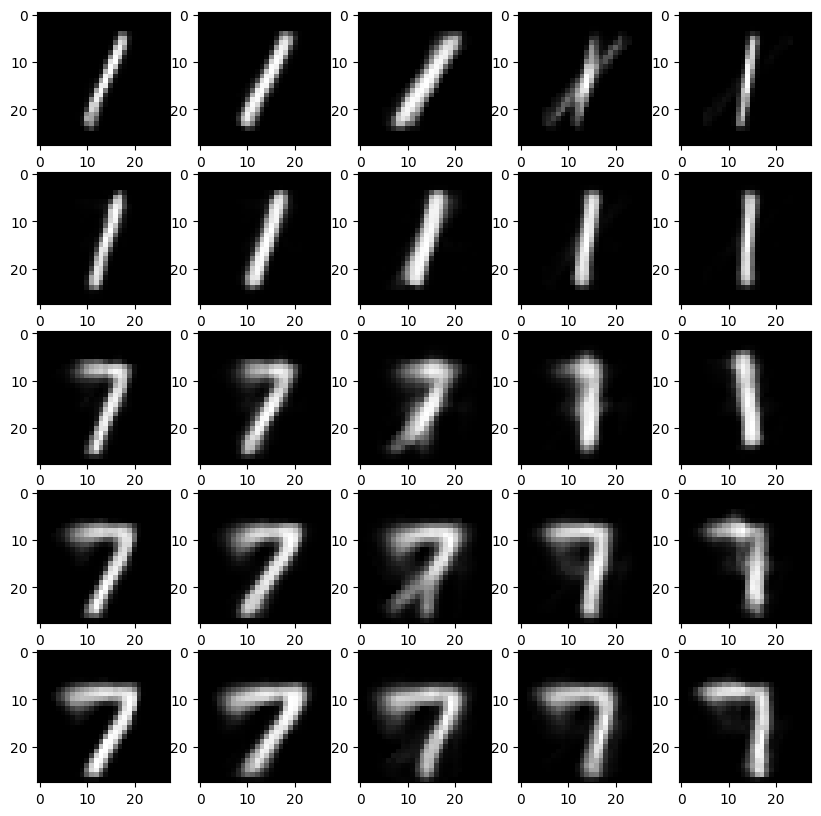

In [198]:
x = np.arange(-1, 1.1, 0.5)
y = np.arange(-1, 1.1, 0.5)

xx, yy = np.meshgrid(x, y)
data = np.array([xx.ravel(), yy.ravel()]).T

list_generated_image = []
for i in data:
    list_generated_image.append(decoder.predict(i.reshape(1,2)))

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
cnt=0
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(list_generated_image[cnt].reshape(28,28), cmap="gray")
        cnt+=1
plt.show()

In [199]:
# データをエンコーダーに入力して、平均、分散、サンプルを得ます。
z_mean, z_log_var, z = encoder.predict(data_2class_train, batch_size=batch_size)

print(z_mean)
print(z_log_var)
print(z)

x = z[:, 0]
y = z[:, 1]

# Create a regular grid to evaluate the kernel density estimator
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values1 = np.vstack([x[label_2class_train==class1], y[label_2class_train==class1]])
kernel1 = kde.gaussian_kde(values1)
f1 = np.reshape(kernel1(positions).T, xx.shape)

values2 = np.vstack([x[label_2class_train==class2], y[label_2class_train==class2]])
kernel2 = kde.gaussian_kde(values2)
f2 = np.reshape(kernel2(positions).T, xx.shape)


102/102 [==============================] - 0s 3ms/step
[[-0.16818605 -1.1179419 ]
 [ 1.1934882   0.0888312 ]
 [ 1.614045   -0.21702264]
 ...
 [-0.12454349  0.28193906]
 [-0.5384066   0.18589778]
 [-0.12185198  0.4633035 ]]
[[-2.61377   -2.2224946]
 [-1.941045  -2.7772229]
 [-1.6436871 -2.787393 ]
 ...
 [-3.8321962 -3.4357347]
 [-2.5505447 -2.886435 ]
 [-3.6983452 -3.221122 ]]
[[-0.25944325 -1.0441923 ]
 [ 1.1970927   0.20046431]
 [ 1.7533709  -0.18021254]
 ...
 [-0.11307532  0.2654593 ]
 [-0.5797041   0.1126275 ]
 [-0.15384719  0.45949355]]


/tmp/ipykernel_379/2900137731.py:19: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kernel1 = kde.gaussian_kde(values1)
/tmp/ipykernel_379/2900137731.py:23: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kernel2 = kde.gaussian_kde(values2)


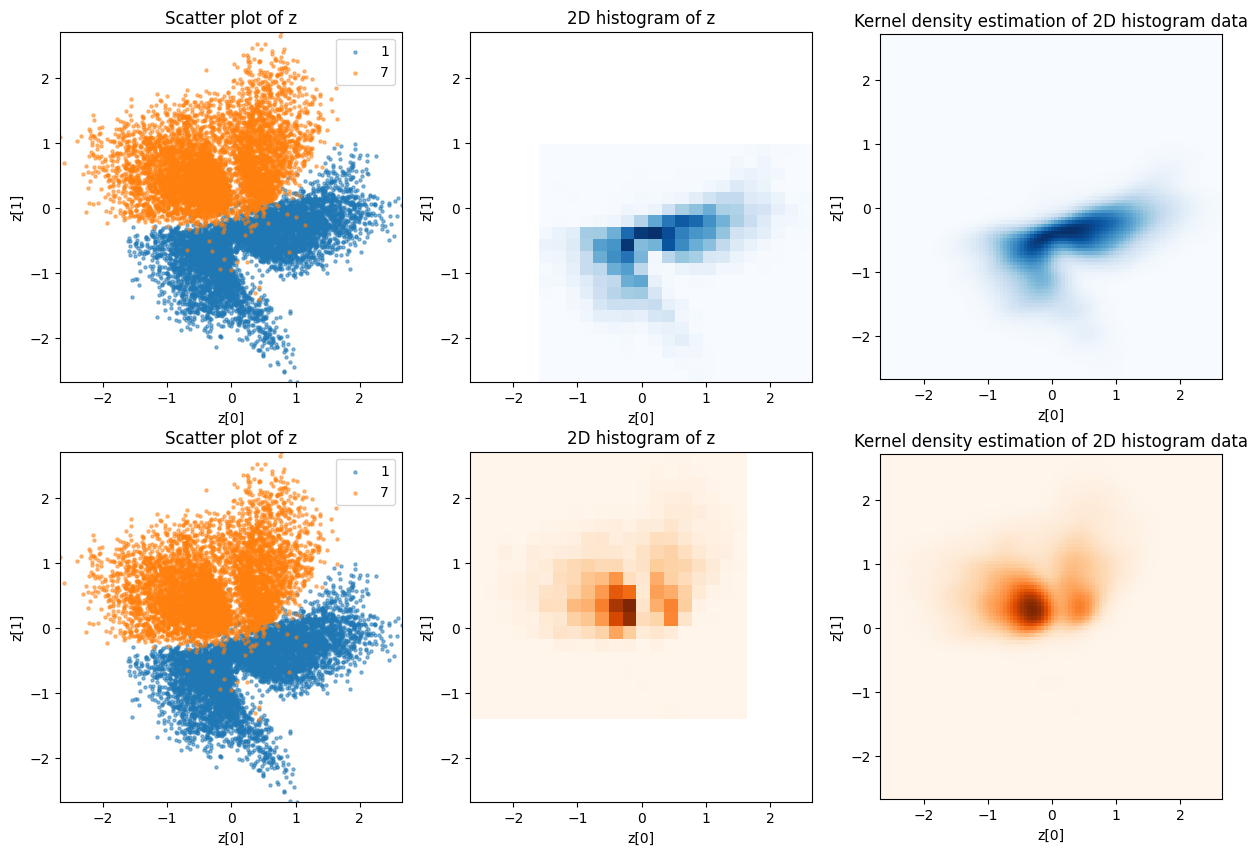

In [200]:
# Plot the results
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0][0].scatter(x[label_2class_train==class1], y[label_2class_train==class1], alpha=0.5, label=class1, s=5)
axs[0][0].scatter(x[label_2class_train==class2], y[label_2class_train==class2], alpha=0.5, label=class2, s=5)
axs[0][0].legend()
axs[0][0].set_xlabel("z[0]")
axs[0][0].set_ylabel("z[1]")
axs[0][0].set_title("Scatter plot of z")
axs[0][0].set_xlim([xmin, xmax])
axs[0][0].set_ylim([ymin, ymax])

axs[1][0].scatter(x[label_2class_train==class1], y[label_2class_train==class1], alpha=0.5, label=class1, s=5)
axs[1][0].scatter(x[label_2class_train==class2], y[label_2class_train==class2], alpha=0.5, label=class2, s=5)
axs[1][0].legend()
axs[1][0].set_xlabel("z[0]")
axs[1][0].set_ylabel("z[1]")
axs[1][0].set_title("Scatter plot of z")
axs[1][0].set_xlim([xmin, xmax])
axs[1][0].set_ylim([ymin, ymax])


axs[0][1].hist2d(x[label_2class_train==class1], y[label_2class_train==class1], bins=20, cmap='Blues')
axs[0][1].set_xlabel("z[0]")
axs[0][1].set_ylabel("z[1]")
axs[0][1].set_title("2D histogram of z")
axs[0][1].set_xlim([xmin, xmax])
axs[0][1].set_ylim([ymin, ymax])

axs[1][1].hist2d(x[label_2class_train==class2], y[label_2class_train==class2], bins=20, cmap='Oranges')
axs[1][1].set_xlabel("z[0]")
axs[1][1].set_ylabel("z[1]")
axs[1][1].set_title("2D histogram of z")
axs[1][1].set_xlim([xmin, xmax])
axs[1][1].set_ylim([ymin, ymax])

axs[0][2].imshow(np.rot90(f1), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# axs[0][2].plot(x, y, 'k.', markersize=2)
axs[0][2].set_xlim([xmin, xmax])
axs[0][2].set_ylim([ymin, ymax])
axs[0][2].set_xlabel("z[0]")
axs[0][2].set_ylabel("z[1]")
axs[0][2].set_title("Kernel density estimation of 2D histogram data")

axs[1][2].imshow(np.rot90(f2), cmap='Oranges', extent=[xmin, xmax, ymin, ymax])
# axs[1][2].plot(x, y, 'k.', markersize=2)
axs[1][2].set_xlim([xmin, xmax])
axs[1][2].set_ylim([ymin, ymax])
axs[1][2].set_xlabel("z[0]")
axs[1][2].set_ylabel("z[1]")
axs[1][2].set_title("Kernel density estimation of 2D histogram data")

plt.show()

In [201]:
cls_ood = 0

# データをエンコーダーに入力して、平均、分散、サンプルを得ます。
z_mean, z_log_var, z = encoder.predict(data_train[cls_ood], batch_size=batch_size)

x_ood = z[:, 0]
y_ood = z[:, 1]

# Create a regular grid to evaluate the kernel density estimator
values_ood = np.vstack([x_ood, y_ood])
kernel_ood = kde.gaussian_kde(values_ood)
f_ood = np.reshape(kernel_ood(positions).T, xx.shape)

47/47 [==============================] - 0s 3ms/step


/tmp/ipykernel_379/253192480.py:11: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kernel_ood = kde.gaussian_kde(values_ood)


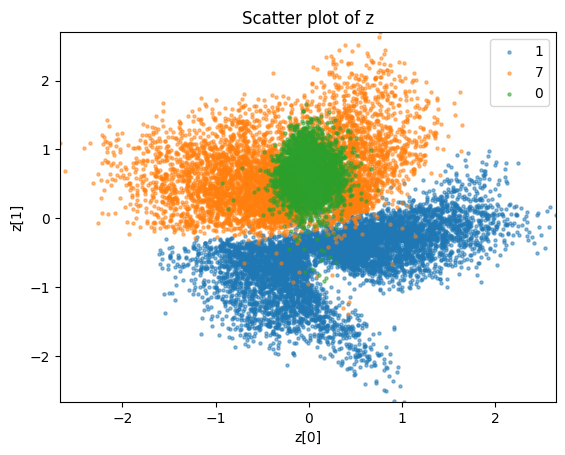

In [202]:
plt.scatter(x[label_2class_train==class1], y[label_2class_train==class1], alpha=0.5, label=class1, s=5)
plt.scatter(x[label_2class_train==class2], y[label_2class_train==class2], alpha=0.5, label=class2, s=5)
plt.scatter(x_ood, y_ood, alpha=0.5, label=cls_ood, s=5)
plt.legend()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Scatter plot of z")
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.show()

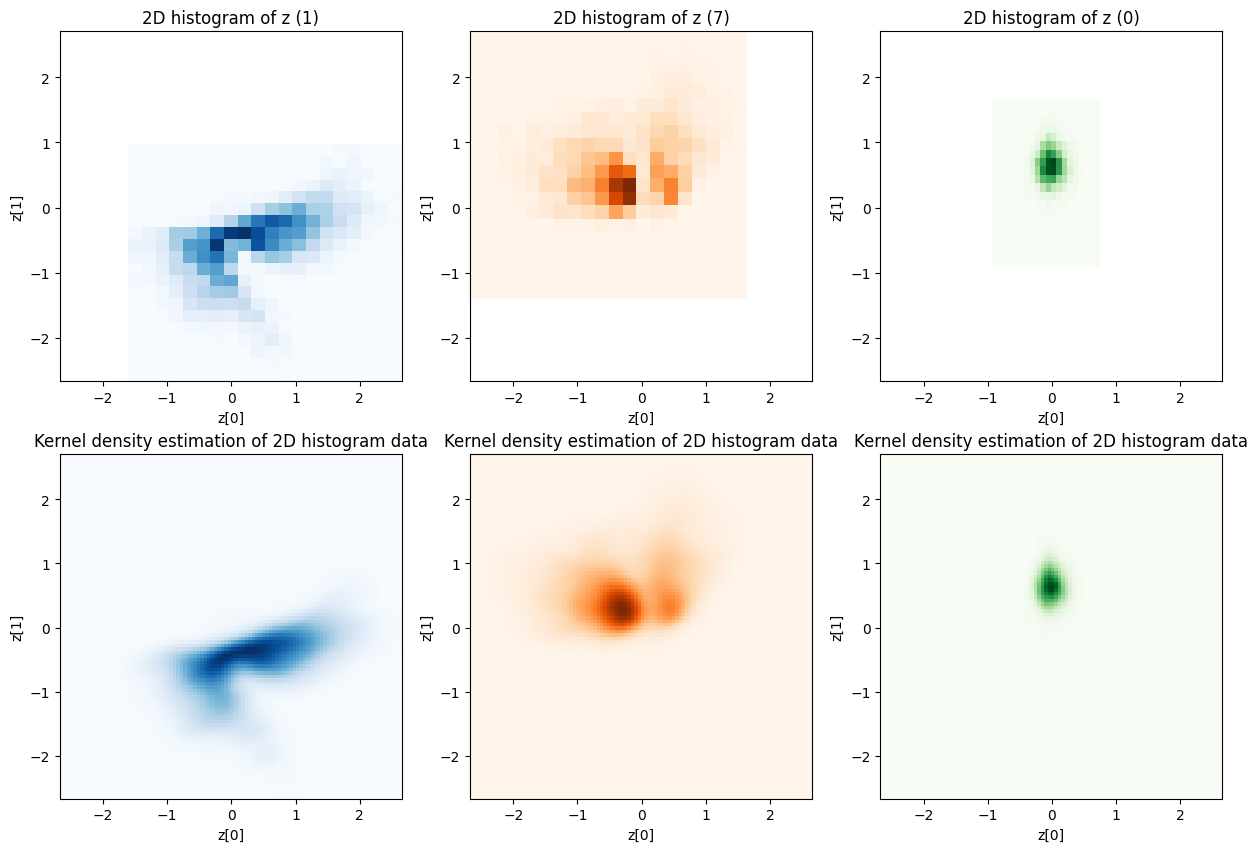

In [203]:
# Plot the results
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0][0].hist2d(x[label_2class_train==class1], y[label_2class_train==class1], bins=20, cmap='Blues')
axs[0][0].set_xlabel("z[0]")
axs[0][0].set_ylabel("z[1]")
axs[0][0].set_title(f"2D histogram of z ({class1})")
axs[0][0].set_xlim([xmin, xmax])
axs[0][0].set_ylim([ymin, ymax])

axs[0][1].hist2d(x[label_2class_train==class2], y[label_2class_train==class2], bins=20, cmap='Oranges')
axs[0][1].set_xlabel("z[0]")
axs[0][1].set_ylabel("z[1]")
axs[0][1].set_title(f"2D histogram of z ({class2})")
axs[0][1].set_xlim([xmin, xmax])
axs[0][1].set_ylim([ymin, ymax])

axs[0][2].hist2d(x_ood, y_ood, bins=20, cmap='Greens')
axs[0][2].set_xlabel("z[0]")
axs[0][2].set_ylabel("z[1]")
axs[0][2].set_title(f"2D histogram of z ({cls_ood})")
axs[0][2].set_xlim([xmin, xmax])
axs[0][2].set_ylim([ymin, ymax])

axs[1][0].imshow(np.rot90(f1), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# axs[1][0].plot(x[label_2class_train==class1], y[label_2class_train==class1], 'k.', markersize=1)
axs[1][0].set_xlim([xmin, xmax])
axs[1][0].set_ylim([ymin, ymax])
axs[1][0].set_xlabel("z[0]")
axs[1][0].set_ylabel("z[1]")
axs[1][0].set_title("Kernel density estimation of 2D histogram data")

axs[1][1].imshow(np.rot90(f2), cmap='Oranges', extent=[xmin, xmax, ymin, ymax])
# axs[1][0].plot(x[label_2class_train==class1], y[label_2class_train==class1], 'k.', markersize=1)
axs[1][1].set_xlim([xmin, xmax])
axs[1][1].set_ylim([ymin, ymax])
axs[1][1].set_xlabel("z[0]")
axs[1][1].set_ylabel("z[1]")
axs[1][1].set_title("Kernel density estimation of 2D histogram data")

axs[1][2].imshow(np.rot90(f_ood), cmap='Greens', extent=[xmin, xmax, ymin, ymax])
# axs[1][0].plot(x[label_2class_train==class1], y[label_2class_train==class1], 'k.', markersize=1)
axs[1][2].set_xlim([xmin, xmax])
axs[1][2].set_ylim([ymin, ymax])
axs[1][2].set_xlabel("z[0]")
axs[1][2].set_ylabel("z[1]")
axs[1][2].set_title("Kernel density estimation of 2D histogram data")

plt.show()

In [204]:
# モデルのパラメータを初期化する
K.clear_session()

# モデルを定義する
model_mlp = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(2, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# モデルをコンパイルする
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model_mlp.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# モデルをトレーニングする
label_t = np.zeros(label_2class_train.shape)
label_t[label_2class_train == class1] = 0
label_t[label_2class_train == class2] = 1
model_mlp.fit(data_2class_train, label_t, epochs=10)


Epoch 1/10
407/407 [==============================] - 4s 7ms/step - loss: 0.3251 - accuracy: 0.9906
Epoch 2/10
407/407 [==============================] - 3s 7ms/step - loss: 0.2429 - accuracy: 0.9955
Epoch 3/10
407/407 [==============================] - 3s 8ms/step - loss: 0.1853 - accuracy: 0.9957
Epoch 4/10
407/407 [==============================] - 3s 7ms/step - loss: 0.1443 - accuracy: 0.9965
Epoch 5/10
407/407 [==============================] - 3s 7ms/step - loss: 0.1159 - accuracy: 0.9962
Epoch 6/10
407/407 [==============================] - 3s 7ms/step - loss: 0.0914 - accuracy: 0.9972
Epoch 7/10
407/407 [==============================] - 3s 7ms/step - loss: 0.0738 - accuracy: 0.9978
Epoch 8/10
407/407 [==============================] - 3s 7ms/step - loss: 0.0608 - accuracy: 0.9977
Epoch 9/10
407/407 [==============================] - 3s 7ms/step - loss: 0.0491 - accuracy: 0.9986
Epoch 10/10
407/407 [==============================] - 3s 7ms/step - loss: 0.0415 - accuracy: 0.9984

In [205]:

# モデルを評価する
index_c1 = y_test==class1
index_c2 = y_test==class2
data_t = np.concatenate([x_test[index_c1], x_test[index_c2]])
label_t = np.concatenate([np.zeros(len(x_test[index_c1])), np.ones(len(x_test[index_c2]))])
test_loss, test_acc = model_mlp.evaluate(data_t, label_t)

# 結果を出力する
print(f'テスト用データに対する損失: {test_loss:.4f}')
print(f'テスト用データに対する精度: {test_acc:.4f}')

68/68 [==============================] - 0s 4ms/step - loss: 0.0579 - accuracy: 0.9898
テスト用データに対する損失: 0.0579
テスト用データに対する精度: 0.9898


In [206]:
intermediate_layer_model = tf.keras.models.Model(inputs=model_mlp.input,
                                                    outputs=model_mlp.layers[-2].output)
intermediate_output = intermediate_layer_model.predict(data_2class_train)

407/407 [==============================] - 1s 2ms/step


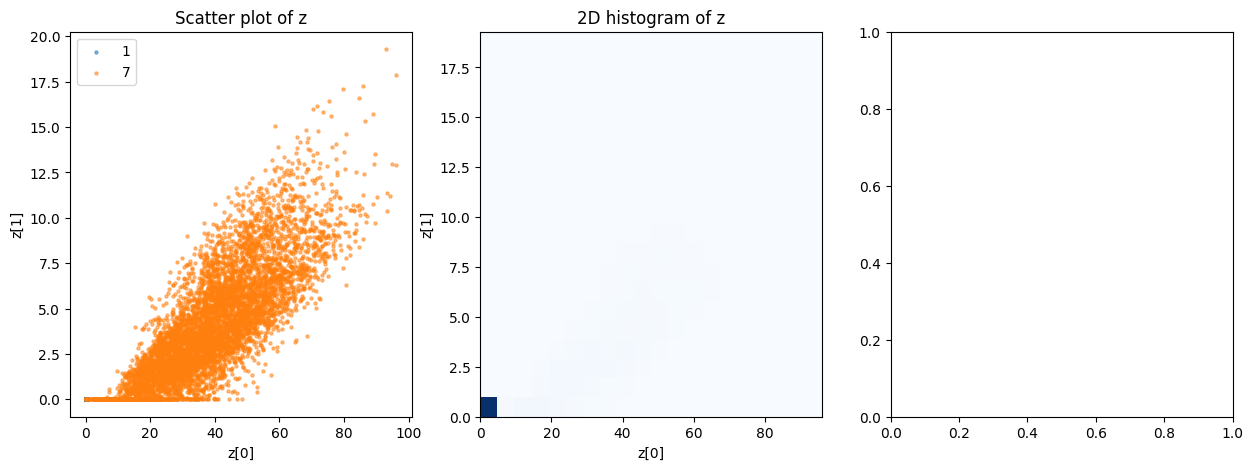

In [207]:
x = intermediate_output[:, 0]
y = intermediate_output[:, 1]

# Create a regular grid to evaluate the kernel density estimator
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
# xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
# positions = np.vstack([xx.ravel(), yy.ravel()])
# values1 = np.vstack([x[label_2class_train==class1], y[label_2class_train==class1]])
# kernel1 = kde.gaussian_kde(values1)
# f1 = np.reshape(kernel1(positions).T, xx.shape)

# values2 = np.vstack([x[label_2class_train==class2], y[label_2class_train==class2]])
# kernel2 = kde.gaussian_kde(values2)
# f2 = np.reshape(kernel2(positions).T, xx.shape)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(x[label_2class_train==class1], y[label_2class_train==class1], alpha=0.5, label=class1, s=5)
axs[0].scatter(x[label_2class_train==class2], y[label_2class_train==class2], alpha=0.5, label=class2, s=5)
axs[0].legend()
axs[0].set_xlabel("z[0]")
axs[0].set_ylabel("z[1]")
axs[0].set_title("Scatter plot of z")

axs[1].hist2d(x, y, bins=20, cmap='Blues')
axs[1].set_xlabel("z[0]")
axs[1].set_ylabel("z[1]")
axs[1].set_title("2D histogram of z")

# axs[2].imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# # axs[2].plot(x, y, 'k.', markersize=2)
# axs[2].set_xlim([xmin, xmax])
# axs[2].set_ylim([ymin, ymax])
# axs[2].set_xlabel("z[0]")
# axs[2].set_ylabel("z[1]")
# axs[2].set_title("Kernel density estimation of 2D histogram data")

plt.show()

2クラス分類が1次元で事足りてしまっているので、ヒストグラムデータの共分散行列が特異行列になり（逆行列が存在しない）KDEが動かなかった。

/tmp/ipykernel_379/2625416331.py:16: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kernel2 = kde.gaussian_kde(values2)


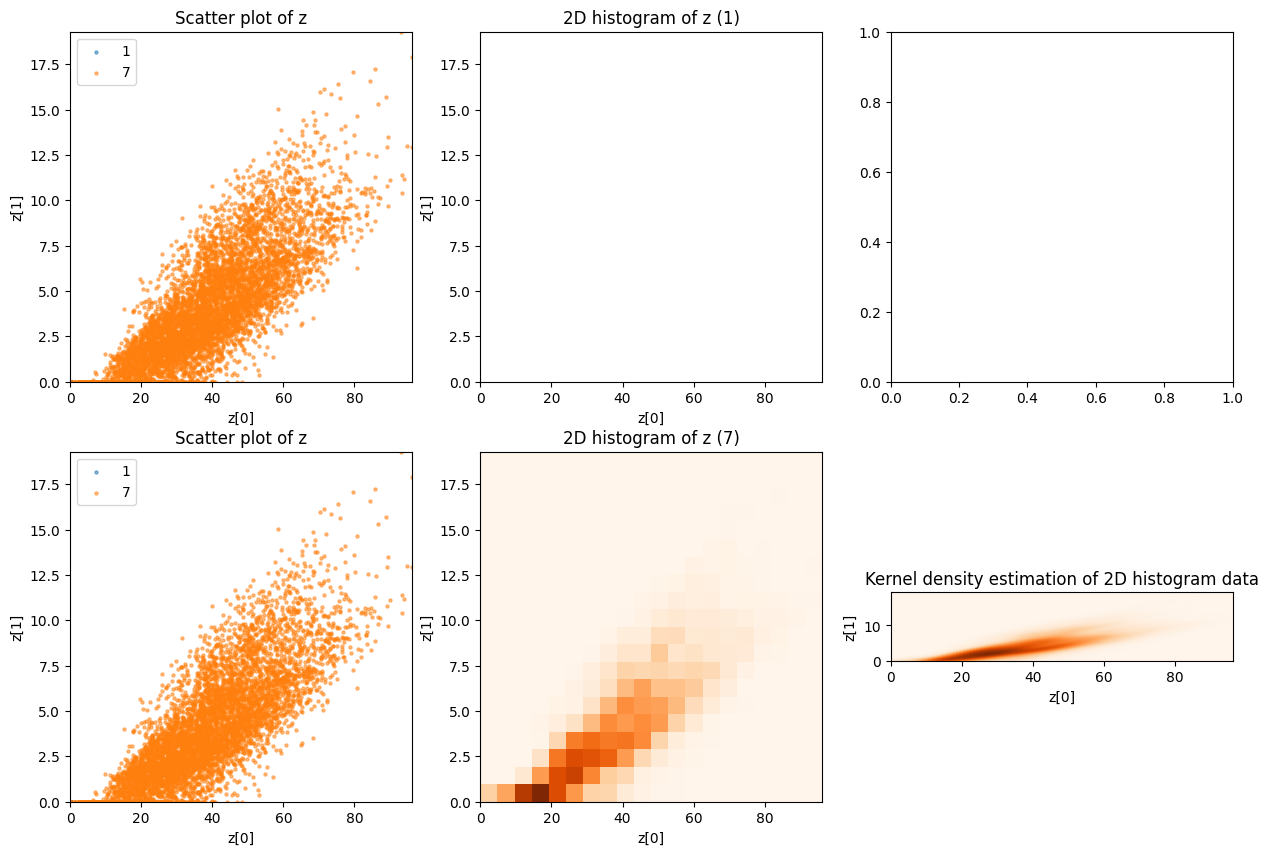

In [208]:
x = intermediate_output[:, 0]
y = intermediate_output[:, 1]

# Create a regular grid to evaluate the kernel density estimator
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
# values1 = np.vstack([x[label_2class_train==class1], y[label_2class_train==class1]])
# kernel1 = kde.gaussian_kde(values1)
# f1 = np.reshape(kernel1(positions).T, xx.shape)

values2 = np.vstack([x[label_2class_train==class2], y[label_2class_train==class2]])
kernel2 = kde.gaussian_kde(values2)
f2 = np.reshape(kernel2(positions).T, xx.shape)


# Plot the results
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0][0].scatter(x[label_2class_train==class1], y[label_2class_train==class1], alpha=0.5, label=class1, s=5)
axs[0][0].scatter(x[label_2class_train==class2], y[label_2class_train==class2], alpha=0.5, label=class2, s=5)
axs[0][0].legend()
axs[0][0].set_xlabel("z[0]")
axs[0][0].set_ylabel("z[1]")
axs[0][0].set_title("Scatter plot of z")
axs[0][0].set_xlim([xmin, xmax])
axs[0][0].set_ylim([ymin, ymax])

axs[1][0].scatter(x[label_2class_train==class1], y[label_2class_train==class1], alpha=0.5, label=class1, s=5)
axs[1][0].scatter(x[label_2class_train==class2], y[label_2class_train==class2], alpha=0.5, label=class2, s=5)
axs[1][0].legend()
axs[1][0].set_xlabel("z[0]")
axs[1][0].set_ylabel("z[1]")
axs[1][0].set_title("Scatter plot of z")
axs[1][0].set_xlim([xmin, xmax])
axs[1][0].set_ylim([ymin, ymax])


axs[0][1].hist2d(x[label_2class_train==class1], y[label_2class_train==class1], bins=20, cmap='Blues')
axs[0][1].set_xlabel("z[0]")
axs[0][1].set_ylabel("z[1]")
axs[0][1].set_title(f"2D histogram of z ({class1})")
axs[0][1].set_xlim([xmin, xmax])
axs[0][1].set_ylim([ymin, ymax])

axs[1][1].hist2d(x[label_2class_train==class2], y[label_2class_train==class2], bins=20, cmap='Oranges')
axs[1][1].set_xlabel("z[0]")
axs[1][1].set_ylabel("z[1]")
axs[1][1].set_title(f"2D histogram of z ({class2})")
axs[1][1].set_xlim([xmin, xmax])
axs[1][1].set_ylim([ymin, ymax])

# axs[0][2].imshow(np.rot90(f1), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# # axs[0][2].plot(x, y, 'k.', markersize=2)
# axs[0][2].set_xlim([xmin, xmax])
# axs[0][2].set_ylim([ymin, ymax])
# axs[0][2].set_xlabel("z[0]")
# axs[0][2].set_ylabel("z[1]")
# axs[0][2].set_title("Kernel density estimation of 2D histogram data")

axs[1][2].imshow(np.rot90(f2), cmap='Oranges', extent=[xmin, xmax, ymin, ymax])
# axs[1][2].plot(x, y, 'k.', markersize=2)
axs[1][2].set_xlim([xmin, xmax])
axs[1][2].set_ylim([ymin, ymax])
axs[1][2].set_xlabel("z[0]")
axs[1][2].set_ylabel("z[1]")
axs[1][2].set_title("Kernel density estimation of 2D histogram data")

plt.show()

In [209]:
x[label_2class_train==class1], y[label_2class_train==class1]

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [210]:
intermediate_output = intermediate_layer_model.predict(data_train[cls_ood])

186/186 [==============================] - 0s 2ms/step


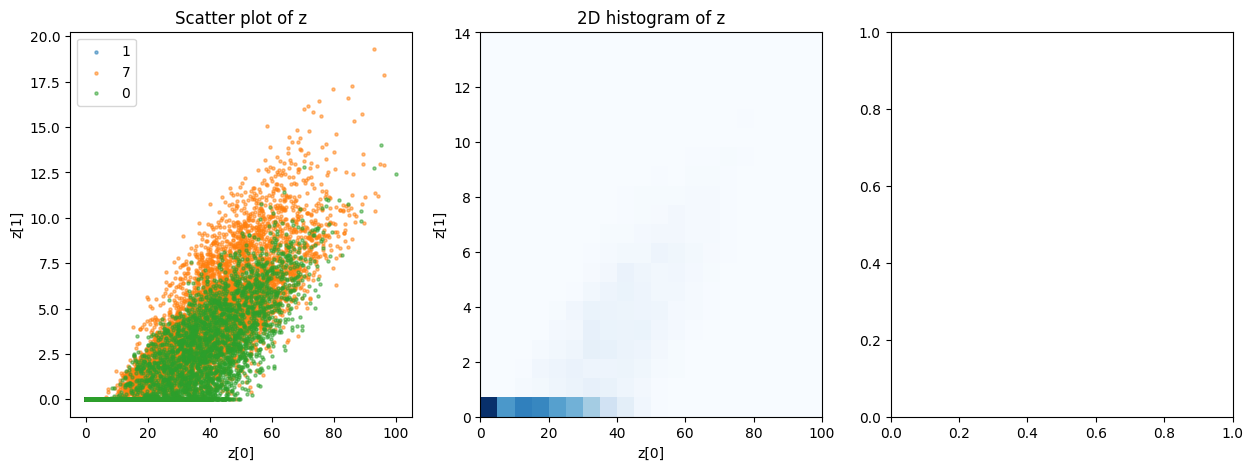

In [211]:
x_ood = intermediate_output[:, 0]
y_ood = intermediate_output[:, 1]

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(x[label_2class_train==class1], y[label_2class_train==class1], alpha=0.5, label=class1, s=5)
axs[0].scatter(x[label_2class_train==class2], y[label_2class_train==class2], alpha=0.5, label=class2, s=5)
axs[0].scatter(x_ood, y_ood, alpha=0.5, label=cls_ood, s=5)
axs[0].legend()
axs[0].set_xlabel("z[0]")
axs[0].set_ylabel("z[1]")
axs[0].set_title("Scatter plot of z")

axs[1].hist2d(x_ood, y_ood, bins=20, cmap='Blues')
axs[1].set_xlabel("z[0]")
axs[1].set_ylabel("z[1]")
axs[1].set_title("2D histogram of z")

plt.show()

In [212]:
# import tensorflow as tf
# from tensorflow.keras.datasets import mnist

# データセットの読み込み
(x_train, _), (x_test, _) = mnist.load_data()

# データの前処理
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# オートエンコーダの定義
input_img = Input(shape=(original_dim,), name='encoder_input')
# input_img = tf.keras.layers.Input(shape=(28, 28, 1))
# x = tf.keras.layers.Flatten()(input_img)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(input_img)
x = tf.keras.layers.Dense(256, activation='relu')(x)
encoded = tf.keras.layers.Dense(latent_dim, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(encoded)
x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dense(784, activation='sigmoid')(x)
# decoded = tf.keras.layers.Reshape((28, 28, 1))(x)
decoded = Dense(original_dim, activation='sigmoid')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# オートエンコーダの学習
autoencoder.fit(data_2class_train, data_2class_train,
                epochs=10,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(data_2class_test, data_2class_test))

# テストデータでのオートエンコーダの性能評価
# decoded_imgs = autoencoder.predict(x_test)



Epoch 1/10
102/102 [==============================] - 2s 9ms/step - loss: 0.0699 - val_loss: 0.0475
Epoch 2/10
102/102 [==============================] - 1s 8ms/step - loss: 0.0434 - val_loss: 0.0410
Epoch 3/10
102/102 [==============================] - 1s 7ms/step - loss: 0.0396 - val_loss: 0.0366
Epoch 4/10
102/102 [==============================] - 1s 8ms/step - loss: 0.0338 - val_loss: 0.0271
Epoch 5/10
102/102 [==============================] - 1s 8ms/step - loss: 0.0256 - val_loss: 0.0233
Epoch 6/10
102/102 [==============================] - 1s 8ms/step - loss: 0.0230 - val_loss: 0.0220
Epoch 7/10
102/102 [==============================] - 1s 8ms/step - loss: 0.0217 - val_loss: 0.0209
Epoch 8/10
102/102 [==============================] - 1s 7ms/step - loss: 0.0211 - val_loss: 0.0205
Epoch 9/10
102/102 [==============================] - 1s 8ms/step - loss: 0.0207 - val_loss: 0.0204
Epoch 10/10
102/102 [==============================] - 1s 8ms/step - loss: 0.0204 - val_loss: 0.0199

1/1 [==============================] - 0s 20ms/step


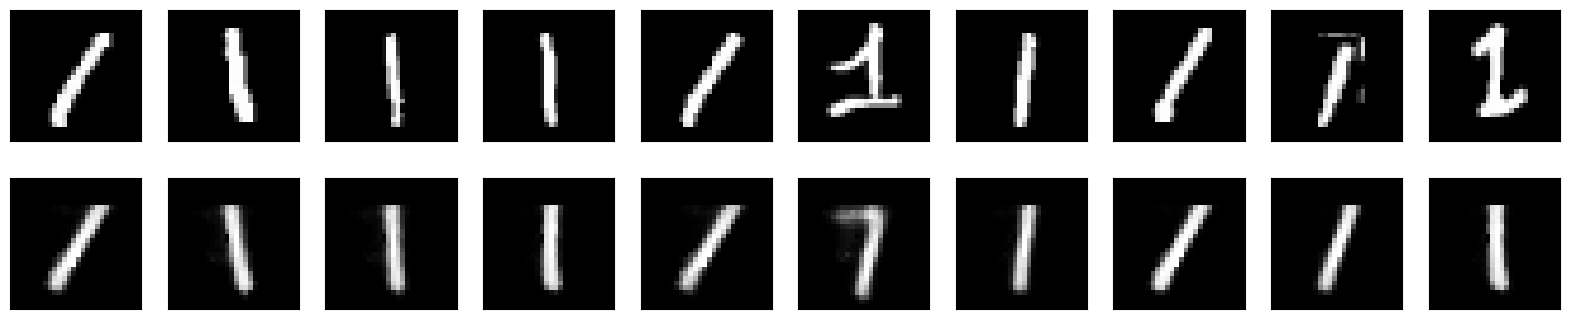

In [213]:
# テストデータの再構成画像を表示
n = 10  # 表示する画像の数
plt.figure(figsize=(20, 4))
for i in range(n):
    # テストデータを入力し、再構成画像を生成
    # reconstructed_img = autoencoder.predict(x_test[i].reshape(1, 28, 28, 1))
    reconstructed_img = autoencoder.predict(data_2class_train[i].reshape(1, original_dim))

    # 元の画像を表示
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data_2class_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 再構成された画像を表示
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_img.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()